In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from skimage.feature import local_binary_pattern
import random
import seaborn as sns

## Get Modified Dataset for Training

In [20]:

# Loading feather files
if True:
    Combined_Feature_train_df = pd.read_feather('Garbage_data/Combined_Feature_train.feather')
    Combined_Feature_val_df = pd.read_feather('Garbage_data/Combined_Feature_val.feather')

In [21]:

# seperate training and validation dataframes between features and labels

X_train = Combined_Feature_train_df.iloc[:, :-1].values
X_val = Combined_Feature_val_df.iloc[:, :-1].values

y_train = Combined_Feature_train_df['label'].values
y_val = Combined_Feature_val_df['label'].values

## Pipeline

In [10]:
scaler = StandardScaler()

In [39]:
# SVM pipeline using one-vs-one organization to do multi-class classification
SVM_pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=50)),
                ('svc', svm.SVC(kernel='rbf', decision_function_shape='ovo', C=.5))])

In [40]:
# performs cross validation with our just our training set


train_sizes, train_scores, val_scores = learning_curve(
    SVM_pipe,
    X_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 6),
    scoring="accuracy",
    n_jobs=-1
)

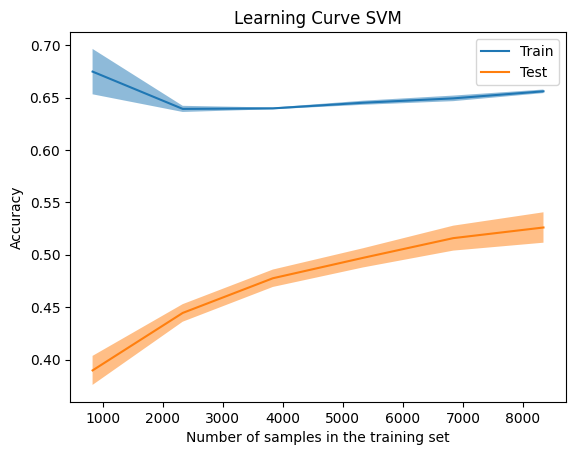

In [41]:
# display results of learning curve scores

disp = LearningCurveDisplay(
    train_sizes=train_sizes,
    train_scores=train_scores,
    test_scores=val_scores,
    score_name="Accuracy"
)

disp.plot()
plt.title("Learning Curve SVM")
plt.show()

In [31]:
val_scores

array([[0.42302158, 0.42781775, 0.4206235 , 0.43932854, 0.43021583],
       [0.51654676, 0.49304556, 0.49736211, 0.51270983, 0.49448441],
       [0.5501199 , 0.54244604, 0.55107914, 0.56306954, 0.54484412],
       [0.58896882, 0.58992806, 0.58177458, 0.5942446 , 0.58081535],
       [0.6206235 , 0.60959233, 0.62494005, 0.63069544, 0.61390887],
       [0.65755396, 0.64316547, 0.65275779, 0.64508393, 0.62733813]])

In [32]:
train_scores

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 0.99981263, 1.        , 1.        ],
       [1.        , 1.        , 0.99970752, 0.99985376, 1.        ],
       [0.99976019, 0.99964029, 0.9998801 , 0.99976019, 0.99976019]])

In [45]:
# RandomForest pipeline
RF_pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=20)),
                ('rf', RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=5))])

In [46]:
# performs cross validation using RandomForest Estimator


train_sizes, train_scores, val_scores = learning_curve(
    RF_pipe,
    X_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 6),
    scoring="accuracy",
    n_jobs=-1
)

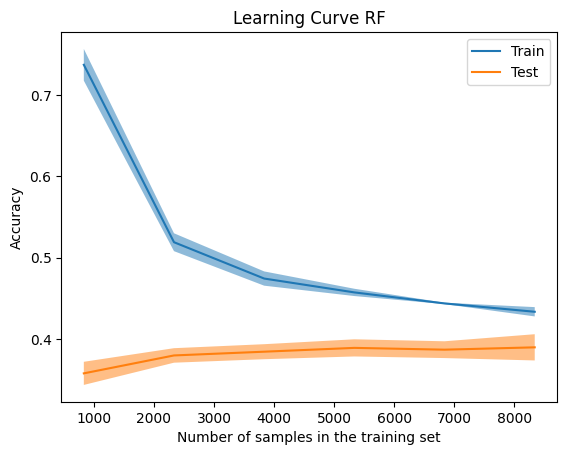

In [47]:
# display results of learning curve scores

disp = LearningCurveDisplay(
    train_sizes=train_sizes,
    train_scores=train_scores,
    test_scores=val_scores,
    score_name="Accuracy"
)

disp.plot()
plt.title("Learning Curve RF")
plt.show()